In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import os
os.getcwd()

'C:\\Users\\Nur Aini Mahfud'

# Import File CSV ke DataFrame

In [3]:
path = r"C:\Users\Nur Aini Mahfud\Downloads\Salinan Salinan Online Retail Data.csv"
df = pd.read_csv(path)
df

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN
...,...,...,...,...,...,...,...
461768,539991,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2010-12-23 16:49:00,1.25,NaN
461769,539991,72741,GRAND CHOCOLATECANDLE,4,2010-12-23 16:49:00,1.45,NaN
461770,539992,21470,FLOWER VINE RAFFIA FOOD COVER,1,2010-12-23 17:41:00,3.75,NaN
461771,539992,22258,FELT FARM ANIMAL RABBIT,1,2010-12-23 17:41:00,1.25,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data Cleansing

In [5]:
df_clean = df.copy()
df_clean['date'] = pd.to_datetime(df_clean['order_date']).dt.date.astype('datetime64[ns]')
df_clean = df_clean[~df_clean['customer_id'].isna()]
df_clean = df_clean[~df_clean['product_name'].isna()]
df_clean['product_name'] = df_clean['product_name'].str.lower()
df_clean = df_clean[(~df_clean['product_code'].str.lower().str.contains('test')) |
                    (~df_clean['product_name'].str.contains('test '))]
df_clean = df_clean[df_clean['order_id'].str[:1]!='C']
df_clean['quantity'] = df_clean['quantity'].abs()
df_clean = df_clean[df_clean['price']>0]
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

In [6]:
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
df_clean['customer_id'] = df_clean['customer_id'].astype(str)

from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)
df_clean

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,amount
0,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,91.80
1,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,51.00
2,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,5.10
3,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,8.50
4,493414,21527,red retrospot traditional teapot,12,2010-01-04 10:28:00,6.95,14590.0,2010-01-04,83.40
...,...,...,...,...,...,...,...,...,...
350087,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,1.25
350088,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,1.69
350089,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,1.69
350090,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12-23,9.90


In [7]:
df_clean.to_csv('Product_Retail_Raw_MBA.csv', index=False)

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350092 entries, 0 to 350091
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      350092 non-null  object        
 1   product_code  350092 non-null  object        
 2   product_name  350092 non-null  object        
 3   quantity      350092 non-null  int64         
 4   order_date    350092 non-null  object        
 5   price         350092 non-null  float64       
 6   customer_id   350092 non-null  object        
 7   date          350092 non-null  datetime64[ns]
 8   amount        350092 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 24.0+ MB


# Preparing Data Basket

**1.Create DataFrame Basket**

In [9]:
basket = pd.pivot_table(df_clean, index='order_id', columns='product_name', values='product_code', aggfunc='nunique', fill_value=0)
basket

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16272 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: int64(3842)
memory usage: 477.1+ MB


**2.Encode DataFrame Basket with True value for all value above 0 and all False value 0**

In [11]:
def encode(x):
    if x==0:
        return False 
    if x>0:
        return True

basket_encode = basket.applymap(encode)
basket_encode

C:\Users\Nur Aini Mahfud\AppData\Local\Temp\ipykernel_7180\354957121.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encode = basket.applymap(encode)


product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539981,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
539982,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
539985,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
basket_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16272 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: bool(3842)
memory usage: 59.7+ MB


**3. Shows transactions of more than 1 unique product**

In [13]:
basket_filter = basket_encode[(basket_encode>0).sum(axis=1)>1]
basket_filter

product_name,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
order_id,,,,,,,,,,,,,,,,,,,,,
493414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493432,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
493433,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539978,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
539981,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
539982,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
basket_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15004 entries, 493414 to 539988
Columns: 3842 entries, 10 colour spaceboy pen to zinc willie winkie  candle stick
dtypes: bool(3842)
memory usage: 55.1+ MB


# Implementation of Apriori Algorithm

**Create List Frequent Itemset (Collection of Frequently Purchased Products)**

In [15]:
from mlxtend.frequent_patterns import apriori

basket_filter = basket_filter.astype('int8')

frequent_itemset = apriori(basket_filter, min_support=.01, use_colnames=True, low_memory=True).sort_values('support', ascending=False).reset_index(drop=True)
frequent_itemset['product_cnt'] = frequent_itemset['itemsets'].apply(lambda x: len(x))
frequent_itemset

C:\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,product_cnt
0,0.177953,(white hanging heart t-light holder),1
1,0.099440,(regency cakestand 3 tier),1
2,0.096841,(jumbo bag red retrospot),1
3,0.079912,(pack of 72 retro spot cake cases),1
4,0.078512,(assorted colour bird ornament),1
...,...,...,...
1189,0.010064,"(lunch bag suki design, jumbo bag red retrosp...",3
1190,0.010064,"(key fob , back door , key fob , front door ,...",3
1191,0.010064,"(lunch bag suki design, lunch bag red spotty,...",3
1192,0.010064,"(poppy's playhouse livingroom, poppy's playhou...",3


# Calculation Support, Confidence, Lift value from Every Possible Product Pair

In [16]:
from mlxtend.frequent_patterns import association_rules 

product_association = association_rules(frequent_itemset, metric='confidence', min_threshold=.7).sort_values(['support', 'confidence'], ascending=[False,False]).reset_index(drop=True)
product_association

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(red hanging heart t-light holder),(white hanging heart t-light holder),0.058784,0.177953,0.042455,0.722222,4.058510,1.0,0.031995,2.959371,0.800671,0.218525,0.662090,0.480400
1,(sweetheart ceramic trinket box),(strawberry ceramic trinket box),0.049254,0.074980,0.037457,0.760487,10.142533,1.0,0.033764,3.862089,0.948103,0.431644,0.741073,0.630021
2,(toilet metal sign),(bathroom metal sign),0.026993,0.040589,0.021728,0.804938,19.831353,1.0,0.020632,4.918499,0.975918,0.473837,0.796686,0.670121
3,(red retrospot sugar jam bowl),(red retrospot small milk jug),0.023660,0.037123,0.016796,0.709859,19.121592,1.0,0.015917,3.318652,0.970669,0.381818,0.698673,0.581141
4,(painted metal pears assorted),(assorted colour bird ornament),0.021927,0.078512,0.016596,0.756839,9.639738,1.0,0.014874,3.789618,0.916356,0.197933,0.736121,0.484107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,"(green 3 piece mini dots cutlery set, blue 3 p...",(pink 3 piece mini dots cutlery set),0.011464,0.029992,0.010064,0.877907,29.271370,1.0,0.009720,7.944827,0.977037,0.320594,0.874132,0.606731
82,"(pink 3 piece mini dots cutlery set, green 3 p...",(blue 3 piece mini dots cutlery set),0.011997,0.030525,0.010064,0.838889,27.481853,1.0,0.009698,6.017430,0.975313,0.310062,0.833816,0.584292
83,"(key fob , back door , key fob , front door )","(key fob , shed)",0.012463,0.025060,0.010064,0.807487,32.222153,1.0,0.009752,5.064272,0.981194,0.366505,0.802538,0.604541
84,"(poppy's playhouse livingroom, poppy's playhou...",(poppy's playhouse bathroom),0.013730,0.010997,0.010064,0.733010,66.655016,1.0,0.009913,3.704266,0.998709,0.686364,0.730041,0.824081


In [17]:
product_association_simple = product_association[['antecedents','consequents','antecedent support', 'consequent support', 'support','confidence','lift', 'leverage', 'conviction']]
product_association_simple

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(red hanging heart t-light holder),(white hanging heart t-light holder),0.058784,0.177953,0.042455,0.722222,4.058510,0.031995,2.959371
1,(sweetheart ceramic trinket box),(strawberry ceramic trinket box),0.049254,0.074980,0.037457,0.760487,10.142533,0.033764,3.862089
2,(toilet metal sign),(bathroom metal sign),0.026993,0.040589,0.021728,0.804938,19.831353,0.020632,4.918499
3,(red retrospot sugar jam bowl),(red retrospot small milk jug),0.023660,0.037123,0.016796,0.709859,19.121592,0.015917,3.318652
4,(painted metal pears assorted),(assorted colour bird ornament),0.021927,0.078512,0.016596,0.756839,9.639738,0.014874,3.789618
...,...,...,...,...,...,...,...,...,...
81,"(green 3 piece mini dots cutlery set, blue 3 p...",(pink 3 piece mini dots cutlery set),0.011464,0.029992,0.010064,0.877907,29.271370,0.009720,7.944827
82,"(pink 3 piece mini dots cutlery set, green 3 p...",(blue 3 piece mini dots cutlery set),0.011997,0.030525,0.010064,0.838889,27.481853,0.009698,6.017430
83,"(key fob , back door , key fob , front door )","(key fob , shed)",0.012463,0.025060,0.010064,0.807487,32.222153,0.009752,5.064272
84,"(poppy's playhouse livingroom, poppy's playhou...",(poppy's playhouse bathroom),0.013730,0.010997,0.010064,0.733010,66.655016,0.009913,3.704266


In [30]:
product_association_simple = product_association[['antecedents', 'consequents', 
                                                  'antecedent support', 'consequent support', 
                                                  'support', 'confidence', 'lift', 
                                                  'leverage', 'conviction']].copy()

In [31]:
product_association_simple.loc[:, 'concatenated_rules'] = (
    product_association_simple['antecedents'].apply(lambda x: ', '.join(list(x))) + 
    ' -> ' + 
    product_association_simple['consequents'].apply(lambda x: ', '.join(list(x)))
)
product_association_simple

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,concatenated_rules
0,(red hanging heart t-light holder),(white hanging heart t-light holder),0.058784,0.177953,0.042455,0.722222,4.058510,0.031995,2.959371,red hanging heart t-light holder -> white hang...
1,(sweetheart ceramic trinket box),(strawberry ceramic trinket box),0.049254,0.074980,0.037457,0.760487,10.142533,0.033764,3.862089,sweetheart ceramic trinket box -> strawberry c...
2,(toilet metal sign),(bathroom metal sign),0.026993,0.040589,0.021728,0.804938,19.831353,0.020632,4.918499,toilet metal sign -> bathroom metal sign
3,(red retrospot sugar jam bowl),(red retrospot small milk jug),0.023660,0.037123,0.016796,0.709859,19.121592,0.015917,3.318652,red retrospot sugar jam bowl -> red retrospot ...
4,(painted metal pears assorted),(assorted colour bird ornament),0.021927,0.078512,0.016596,0.756839,9.639738,0.014874,3.789618,painted metal pears assorted -> assorted colou...
...,...,...,...,...,...,...,...,...,...,...
81,"(green 3 piece mini dots cutlery set, blue 3 p...",(pink 3 piece mini dots cutlery set),0.011464,0.029992,0.010064,0.877907,29.271370,0.009720,7.944827,"green 3 piece mini dots cutlery set, blue 3 pi..."
82,"(pink 3 piece mini dots cutlery set, green 3 p...",(blue 3 piece mini dots cutlery set),0.011997,0.030525,0.010064,0.838889,27.481853,0.009698,6.017430,"pink 3 piece mini dots cutlery set, green 3 pi..."
83,"(key fob , back door , key fob , front door )","(key fob , shed)",0.012463,0.025060,0.010064,0.807487,32.222153,0.009752,5.064272,"key fob , back door , key fob , front door -..."
84,"(poppy's playhouse livingroom, poppy's playhou...",(poppy's playhouse bathroom),0.013730,0.010997,0.010064,0.733010,66.655016,0.009913,3.704266,"poppy's playhouse livingroom, poppy's playhous..."


In [32]:
product_association_sorted = product_association_simple.sort_values(by='lift', ascending=False)
product_association_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,concatenated_rules
64,(childs garden trowel blue),(childs garden fork blue),0.013530,0.011664,0.010864,0.802956,68.843125,0.010706,5.015807,childs garden trowel blue -> childs garden for...
63,(childs garden fork blue),(childs garden trowel blue),0.011664,0.013530,0.010864,0.931429,68.843125,0.010706,14.386025,childs garden fork blue -> childs garden trowe...
79,(poppy's playhouse bathroom),"(poppy's playhouse livingroom, poppy's playhou...",0.010997,0.013730,0.010064,0.915152,66.655016,0.009913,11.623900,poppy's playhouse bathroom -> poppy's playhous...
84,"(poppy's playhouse livingroom, poppy's playhou...",(poppy's playhouse bathroom),0.013730,0.010997,0.010064,0.733010,66.655016,0.009913,3.704266,"poppy's playhouse livingroom, poppy's playhous..."
56,(childs garden fork pink),(childs garden trowel pink),0.012330,0.013996,0.011464,0.929730,66.426976,0.011291,14.031592,childs garden fork pink -> childs garden trowe...
...,...,...,...,...,...,...,...,...,...,...
29,"(jumbo bag baroque black white, jumbo bag pin...",(jumbo bag red retrospot),0.017795,0.096841,0.012930,0.726592,7.502948,0.011207,3.303336,"jumbo bag baroque black white, jumbo bag pink..."
65,"(jumbo storage bag suki, jumbo bag owls)",(jumbo bag red retrospot),0.014996,0.096841,0.010730,0.715556,7.388985,0.009278,3.175169,"jumbo storage bag suki, jumbo bag owls -> jumb..."
13,"(jumbo storage bag suki, jumbo bag strawberry)",(jumbo bag red retrospot),0.020461,0.096841,0.014529,0.710098,7.332626,0.012548,3.115392,"jumbo storage bag suki, jumbo bag strawberry -..."
76,(candleholder pink hanging heart),(white hanging heart t-light holder),0.013796,0.177953,0.010131,0.734300,4.126378,0.007676,3.093888,candleholder pink hanging heart -> white hangi...


In [19]:
product_association_simple.to_csv('Market_Basket_analysis2.csv', index=False)

# DASHBOARD VISUALIZATION

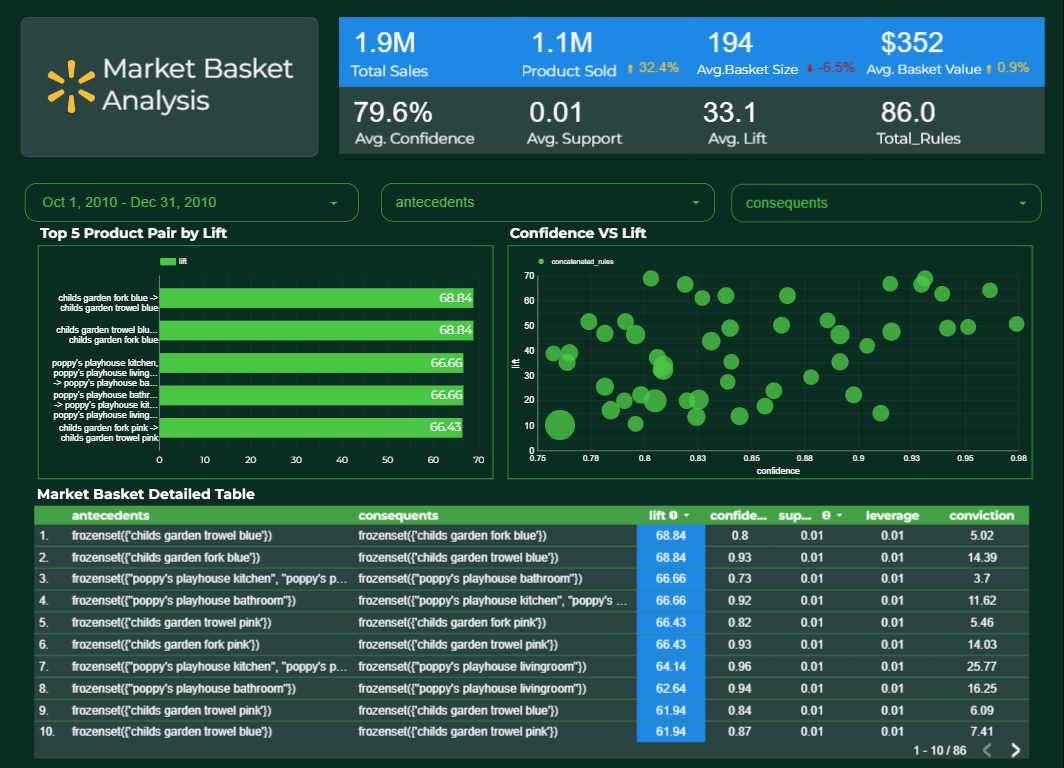

In [29]:
from IPython.display import Image, display

display(Image(filename='Market_Basket_Analysis_Dashboard.png'))

# INSIGHT

- Sales performance for this period was quite good compared to the previous period. Total sales and total product units sold increased despite a decrease in the average basket size.
- Product associations showed strong results with a high confidence value of 79.6% and a 3.1% confidence level.
- There were 86 rules, a sufficient number to make recommendations for product bundle variations.
- Based on this data, to continue maximizing product sales, a focus can be placed on cross-selling strategies and product bundling offers, for example create discount for selling bundling product, "5% off the bundled purchase of Child's Garden Trowel Blue & Child's Garden Fork Blue."